# Winnow: *de novo* sequencing confidence calibration and FDR control tutorial

<a target="_blank" href="https://colab.research.google.com/github/instadeepai/winnow/blob/main/notebooks/getting_started_with_instanovo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook demonstrates how to use the `winnow` package for confidence calibration and false discovery rate (FDR) control in *de novo* sequencing (DNS) workflows.

In the rest of the notebook, you'll:
- Set up the environment and download example datasets.
- Load and filter spectra and beam predictions; inspect key metadata.
- Configure Winnow features (Mass Error, Prosit spectral/iRT, Chimeric, Beam) and train a calibrator on the HeLa Single Shot dataset.
- Evaluate calibration with precision–recall curves, score transformation, confidence distributions, and calibration curves.
- Control FDR via two approaches: database-grounded and label-free empirical Bayes; add per-PSM FDR/PEP/p-values and plot PSM FDR vs. confidence.
- Apply the trained calibrator and label-free FDR to raw, unlabelled HeLa Single Shot data and filter results by a 5% FDR cutoff.
- Extend Winnow: implement a custom feature, save/reload a calibrator, and run the workflow via the CLI.
- Use a minimal (Prosit-free) feature set when Prosit isn't available.
- Load a pretrained general calibrator and reproduce results on another dataset (Immunopeptidomics-2).
- Review tips, troubleshooting notes, and additional resources.

<img src="../assets/winnow-pipeline.png" alt="winnow pipeline" width="600">

## Overview

`winnow` implements a calibrate‑estimate framework for FDR control in *de novo* peptide sequencing. The flow:

1. **Confidence calibration**: Learn a mapping from raw model confidence and auxiliary features to an improved, better‑calibrated probability of correctness.
2. **FDR estimation**: Estimate/control FDR either with labels (database‑grounded) or without labels via a mixture model (empirical Bayes).

## Links

- **Paper**: TODO
- **Code**: [GitHub](https://github.com/instadeepai/winnow)

In [1]:
!uv pip install instanovo

Using Python 3.12.11 environment at: /home/j-vangoey/code/worktree_winnow/.venv
Audited 1 package in 24ms


## 1. Setup and imports

First, let's import all the necessary packages and set up logging.

In [2]:
from winnow.calibration.calibration_features import (
    CalibrationFeatures,
    PrositFeatures,
    MassErrorFeature,
    RetentionTimeFeature,
    ChimericFeatures,
    BeamFeatures,
)
from winnow.calibration.calibrator import ProbabilityCalibrator
from winnow.datasets.calibration_dataset import  CalibrationDataset
from winnow.constants import RESIDUE_MASSES
from winnow.fdr.database_grounded import DatabaseGroundedFDRControl
from winnow.fdr.bayes import EmpiricalBayesFDRControl

import logging
from pathlib import Path
from huggingface_hub import snapshot_download, list_repo_files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")

In [3]:
# -- Set up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

## 2. Data download

Let's download a HeLa single cell dataset and its corresponding InstaNovo predictions from [Hugging Face](https://huggingface.co/datasets/JemmaDaniel/winnow-ms-datasets).

In [4]:
# repo_id = "InstaDeepAI/winnow-ms-datasets"
# save_dir = "winnow-ms-datasets"

# files = list_repo_files(repo_id=repo_id, repo_type="dataset")
# print([f for f in files])

In [5]:
# -- Download the helaqc dataset
# snapshot_download(
#    repo_id=repo_id,
#    repo_type="dataset",
#    allow_patterns=["helaqc*.parquet", "helaqc*.csv"],
#    local_dir=save_dir,
# )

## 3. Data loading and preparation

In a typical workflow, you'll have:
- **Spectrum data**: MS/MS spectra with metadata (charge, m/z, retention time)
- **Beam predictions**: Peptide sequence predictions from your *de novo* model
- **Annotations (Optional)**: Ground truth labels (for training/evaluation)

If you do not have beam predictions (i.e., traditional search enginers or DNS models without beam search), you can submit a predictions list with just a single prediction per spectrum and its associated log-probabilities.

In [6]:
# JVG: Convert mgf file to parquet
from instanovo.utils import SpectrumDataFrame

sdf = SpectrumDataFrame.load("/home/j-vangoey/Downloads/nine-species-balanced/nine-species-balanced/Mus-musculus.mgf", lazy=False, is_annotated=False)
sdf.save("/home/j-vangoey/code/casanovo/output/", partition="train")

In [7]:
sdf.df.head()

scan_number,sequence,precursor_mass,precursor_mz,precursor_charge,retention_time,mz_array,intensity_array,experiment_name,spectrum_id
i64,str,f64,f64,i64,f64,list[f64],list[f64],str,str
0,"""C+57.021GHTNNLRPK""",1195.585912,598.800232,2,825.62256,"[83.777885, 84.044724, … 979.541748]","[613.509949, 1373.269043, … 1175.740234]","""Mus-musculus""","""Mus-musculus:0"""
1,"""VVQEQGTHPK""",1121.583104,561.798828,2,826.27068,"[84.04499, 84.081467, … 925.453674]","[5980.734863, 6190.214355, … 5385.465332]","""Mus-musculus""","""Mus-musculus:1"""
2,"""SLSHSPGK""",811.418859,406.716705,2,827.11986,"[60.045296, 63.988693, … 846.034912]","[5493.098633, 2281.824951, … 668.246582]","""Mus-musculus""","""Mus-musculus:2"""
3,"""HNSYTC+57.021EATHK""",1346.566503,674.290527,2,827.92434,"[93.045326, 101.108047, … 1222.487061]","[41435.902344, 9822.321289, … 11189.466797]","""Mus-musculus""","""Mus-musculus:3"""
4,"""RPDGDAASQPR""",1168.556249,585.2854,2,829.37946,"[83.06073, 84.04509, … 1014.461487]","[1603.393677, 3934.435059, … 5571.429688]","""Mus-musculus""","""Mus-musculus:4"""


In [8]:
# JVG: load Casanovo MZTab
from winnow.datasets.data_loaders import MZTabDatasetLoader
logger.info("Loading dataset.")
mztab_loader = MZTabDatasetLoader()
mztab_dataset = mztab_loader.load(
    "/home/j-vangoey/code/casanovo/output/dataset-ms-train-0000-0001.parquet",
    "/home/j-vangoey/code/casanovo/output/casanovo_20250920232832.mztab",
)
len(mztab_dataset)

Loading dataset.


17800

In [9]:
#logger.info("Loading dataset.")
#dataset = CalibrationDataset.from_predictions_csv(
#    spectrum_path="winnow-ms-datasets/helaqc_labelled.parquet",
#    beam_predictions_path="winnow-ms-datasets/helaqc_labelled_beams.csv",
#)
#len(dataset)

In [10]:
# -- Load data

logger.info("Filtering dataset.")
filtered_dataset = (
    mztab_dataset.filter_entries(
        metadata_predicate=lambda row: not isinstance(row["prediction"], list),
    )
    .filter_entries(metadata_predicate=lambda row: not row["prediction"])
    .filter_entries(
        metadata_predicate=lambda row: row["precursor_charge"] > 6
    )  # Prosit-specific filtering, see https://github.com/Nesvilab/FragPipe/issues/1775
    .filter_entries(
        metadata_predicate=lambda row: len(row["prediction"]) > 30
    )  # Prosit-specific filtering
    .filter_entries(
        predictions_predicate=lambda beam: len(beam[0].sequence) > 30 # JVG: I changed row[1] to beam[0] here
    )  # Prosit-specific filtering
)
len(filtered_dataset)

Filtering dataset.


17754

In [11]:
# JVG: Split MZTab data into train and test sets
# Might be an idea to add a train_test_split function to the dataloader?
import random
n = len(filtered_dataset)
psm_ids = [int(filtered_dataset[i][0].PSM_ID) for i in range(n)]
random.seed(42)
random.shuffle(psm_ids)

train_fraction = 0.8
train_size = int(train_fraction * n)
train_psm_ids = psm_ids[:train_size]
test_psm_ids = psm_ids[train_size:]

# We want to filter out all the rows with PSM_IDs not in train_psm_ids to get the train_dataset
train_dataset = filtered_dataset.filter_entries(
    metadata_predicate=lambda row: row["PSM_ID"] not in train_psm_ids 
)
test_dataset = filtered_dataset.filter_entries(
    metadata_predicate=lambda row: row["PSM_ID"] not in test_psm_ids
)

print("Number of spectra in train set:", len(train_dataset))
print("Number of spectra in test set:", len(test_dataset))

Number of spectra in train set: 14203
Number of spectra in test set: 3551


In [12]:
# -- Split data into train and test sets
#train_dataset = filtered_dataset.filter_entries(
#    metadata_predicate=lambda row: row["split"] == "test"
#)
#test_dataset = filtered_dataset.filter_entries(
#    metadata_predicate=lambda row: row["split"] == "train"
#)

# print("Number of spectra in train set:", len(train_dataset))
# print("Number of spectra in test set:", len(test_dataset))

In [13]:
train_dataset.metadata.head()

,index,scan_number,sequence,precursor_mass,precursor_mz,precursor_charge,retention_time,mz_array,intensity_array,experiment_name,...,start,end,prediction_untokenised,confidence,token_scores,prediction,valid_prediction,valid_peptide,num_matches,correct
0,1,1,"[V, V, Q, E, Q, G, T, H, P, K]",1121.583104,561.798828,2,826.27068,"[84.0449905, 84.0814667, 92.2192078, 96.330497...","[5980.7348632813, 6190.2143554688, 757.8950805...",Mus-musculus,...,None,None,VVQEQGTHPK,0.893418,"[0.99179, 0.98928, 0.99105, 0.98631, 0.99004, ...","[V, V, Q, E, Q, G, T, H, P, K]",False,False,10,True
1,2,2,"[S, I, S, H, S, P, G, K]",811.418859,406.716705,2,827.11986,"[60.0452957, 63.9886932, 63.9921455, 70.065933...","[5493.0986328125, 2281.8249511719, 1321.101440...",Mus-musculus,...,None,None,SISHSPGK,0.917340,"[0.99006, 0.98786, 0.989, 0.99064, 0.99155, 0....","[S, I, S, H, S, P, G, K]",False,False,8,True
2,4,4,"[R, P, D, G, D, A, A, S, Q, P, R]",1168.556249,585.285400,2,829.37946,"[83.06073, 84.0450897, 84.0814362, 86.0971909,...","[1603.3936767578, 3934.4350585938, 23824.48828...",Mus-musculus,...,None,None,RPDGDAASQPR,0.516049,"[0.98958, 0.98994, 0.58038, 0.99311, 0.98462, ...","[R, P, D, G, D, A, A, S, Q, P, R]",False,False,11,True
3,5,5,"[K, P, A, A, A, A, V, T, K]",855.517858,428.766205,2,830.27022,"[63.9970665, 64.000946, 70.0659332, 72.0817337...","[7854.0209960938, 43447.18359375, 63801.691406...",Mus-musculus,...,None,None,KPANVVTK,0.840071,"[0.99422, 0.98956, 0.98817, 0.96228, 0.9416, 0...","[K, P, A, N, V, V, T, K]",False,False,6,False
4,6,6,"[A, H, G, N, S, G, M, V, R]",927.434545,464.724548,2,834.39072,"[70.0660706, 72.0816498, 73.1327896, 73.986213...","[4468.5693359375, 14712.0419921875, 512.960693...",Mus-musculus,...,None,None,AHGNGSMVR,0.417303,"[0.99219, 0.98816, 0.99028, 0.98922, 0.98881, ...","[A, H, G, N, G, S, M, V, R]",False,False,7,False


### Metadata columns

Each row corresponds to an MS2 spectrum with metadata and arrays:
- `spectrum_id` (string): unique spectrum identifier, constructed by concatenating experiment name with scan number
- `sequence_untokenised` (string): ground truth peptide sequence from database search, for labelled data only, as a string
- `prediction_untokenised` (string): model-predicted peptide sequence as a string
- `prediction` (list(string)): model-predicted peptide sequence as a list of amino acids 
- `confidence` (float): model confidence for the top prediction, ranges between 0 and 1
- `token_log_probs` (list(float)): amino acid-level log-probabilities
- `sequence` (string): ground truth peptide sequence from database search, for labelled data only
- `precursor_charge` (int): charge of the precursor (from MS1)
- `precursor_mass` (float): mass of the precursor ion (from MS1)
- `retention_time` (float): retention time (seconds)
- `mz_array` (list[float]): mass-to-charge values of the MS2 spectrum
- `intensity_array` (list[float]): intensity values of the MS2 spectrum
- `split` (string): train, test or validation split identity for the MS2 spectrum (not required by Winnow)
- `valid_peptide` (boolean): whether the entry in `sequence` is of type list
- `valid_prediction` (boolean): whether the entry in `prediction` is of type list
- `num_matches` (integer): number of token-level matches between the sequence and prediction, if labelled
- `correct` (boolean): whether the predicted peptide sequence is correct (i.e., do all tokens match)


In [14]:
# Print the first 3 beam results for the first spectrum
# JVG: I ran the Casanovo predictions with 2 beams, but that doesn't show up here?
train_dataset.predictions[0]

[ScoredSequence(sequence=['V', 'V', 'Q', 'E', 'Q', 'G', 'T', 'H', 'P', 'K'], mass_error=None, sequence_log_probability=0.8934182, token_log_probabilities=[0.99179, 0.98928, 0.99105, 0.98631, 0.99004, 0.99065, 0.9871, 0.99055, 0.9906, 0.99038])]

## 4. Feature engineering deep dive

Below we describe the built‑in features that Winnow can use as complementary signals during the calibration step. Which features are informative depends on the dataset, instrument, acquisition settings and the upstream DNS model. Use the descriptions below to decide what to enable, and validate with ablations on your data.

### Mass error
What it captures: Consistency between the observed precursor mass and the theoretical mass of the predicted peptide (accounting for H2O and a proton).
- Inputs used: `prediction`, `precursor_mass`, plus `RESIDUE_MASSES` for theoretical mass.
- Metadata columns created: `Mass Error`.

### Prosit features
What it captures: How well Prosit‑predicted fragment ions explain the experimental spectrum.
- Implemented as: fraction of matched ions and average matched intensity within an m/z tolerance.
- Inputs used: `prediction`, `mz_array`, `intensity_array`, `precursor_charge`.
- Metadata columns created: `prosit_mz`, `prosit_intensity`, `ion_matches`, `ion_match_intensity`.

### Prosit iRT features
What it captures: Agreement between Prosit iRT (sequence‑based) and observed retention time, via a small RT calibration model trained on high‑confidence PSMs.
- Inputs used: `prediction`, `retention_time`.
- Metadata columns created: `iRT`, `predicted iRT`, `iRT error`.

### Chimeric features
What it captures: Whether runner‑up sequences also explain the spectrum (a proxy for chimericity).
- Implemented as: ion match rate/intensity for the second‑best sequence.
- Inputs used: `prediction` beams, `mz_array`, `intensity_array`, `precursor_charge`.
- Metadata columns created: `runner_up_prosit_mz`, `runner_up_prosit_intensity`, `chimeric_ion_matches`, `chimeric_match_intensity`.

### Beam features
What it captures: Properties of the decoding distribution (margin to runner‑ups, median margin, entropy, and a z‑score of the top beam relative to its peers).
- Inputs used: beam log‑probabilities from the upstream model.
- Metadata columns created: `margin`, `median_margin`, `entropy`, `z-score`.

### Supported modifications and sequence notation

Winnow expects tokenised peptide sequences where modifications are encoded inline using UNIMOD bracket notation. Examples:
- Tokenised format: `A, C[UNIMOD:4], M[UNIMOD:35], Y[UNIMOD:21]`
- Untokenised example (for display): `AC[UNIMOD:4]M[UNIMOD:35]Y[UNIMOD:21]`

Supported modification tokens (parsed via `RESIDUE_MASSES`):
- `C[UNIMOD:4]`: Carbamidomethylation (fixed, C)
- `M[UNIMOD:35]`: Oxidation (M)
- `N[UNIMOD:7]`, `Q[UNIMOD:7]`: Deamidation (N/Q)
- `S[UNIMOD:21]`, `T[UNIMOD:21]`, `Y[UNIMOD:21]`: Phosphorylation (S/T/Y)
- `[UNIMOD:1]`: Acetylation (e.g., N-term)
- `[UNIMOD:5]`: Carbamylation
- `[UNIMOD:385]`: Ammonia loss

Accepted legacy/alternate notations are auto‑remapped to UNIMOD tokens during loading (via `RESIDUE_REMAPPING`):
- `M(ox)`, `M(+15.99)` → `M[UNIMOD:35]`
- `S(p)`, `T(p)`, `Y(p)`, `S(+79.97)`, `T(+79.97)`, `Y(+79.97)` → `*[UNIMOD:21]`
- `Q(+0.98)`, `N(+0.98)`, `Q(+.98)`, `N(+.98)` → `*[UNIMOD:7]`
- `C(+57.02)` → `C[UNIMOD:4]`
- `(+42.01)` → `[UNIMOD:1]`; `(+43.01)` → `[UNIMOD:5]`; `(-17.03)` → `[UNIMOD:385]`

Notation and preprocessing details:
- Sequences are tokenised as comma‑separated tokens in the dataset (e.g., `preds_tokenised`), and Winnow normalises `L` to `I` on load.
- For Prosit‑based features (spectral and iRT): only peptides with supported modifications are queried. Rows with unsupported modifications are filtered. Carbamidomethylation on C (`C[UNIMOD:4]`) is treated as fixed; when querying Prosit, this is internally mapped to `C`.
- If many rows are filtered during Prosit feature computation, review your modification tokens and acquisition settings.

## 5. Calibration workflow

In [15]:
# -- Set up calibrator
logger.info("Initialising calibrator.")
SEED = 42
calibrator = ProbabilityCalibrator(SEED)

logger.info("Adding features to calibrator.")
MZ_TOLERANCE = 0.02
HIDDEN_DIM = 10
TRAIN_FRACTION = 0.1
calibrator.add_feature(MassErrorFeature(residue_masses=RESIDUE_MASSES))
calibrator.add_feature(PrositFeatures(mz_tolerance=MZ_TOLERANCE))
calibrator.add_feature(
    RetentionTimeFeature(hidden_dim=HIDDEN_DIM, train_fraction=TRAIN_FRACTION)
)
# calibrator.add_feature(ChimericFeatures(mz_tolerance=MZ_TOLERANCE)) # JVG: commented out because gives ValueError: Columns must be same length as key"
calibrator.add_feature(BeamFeatures())

Initialising calibrator.
Adding features to calibrator.


In [16]:
# -- Calibrate
logger.info("Calibrating scores.")
calibrator.fit(train_dataset)
calibrator.predict(test_dataset)

Calibrating scores.


Prosit_2020_intensity_HCD::   0%|          | 0/15 [00:00<?, ?it/s]

Prosit_2019_irt::   0%|          | 0/2 [00:00<?, ?it/s]

Prosit_2019_irt::   0%|          | 0/15 [00:00<?, ?it/s]

/home/j-vangoey/code/worktree_winnow/winnow/calibration/calibration_features.py:547: UserWarning: 14203 beam search results have fewer than three sequences. This may affect the efficacy of computed beam features.
  warnings.warn(


Prosit_2020_intensity_HCD::   0%|          | 0/4 [00:00<?, ?it/s]

Prosit_2019_irt::   0%|          | 0/4 [00:00<?, ?it/s]

/home/j-vangoey/code/worktree_winnow/winnow/calibration/calibration_features.py:547: UserWarning: 3551 beam search results have fewer than three sequences. This may affect the efficacy of computed beam features.
  warnings.warn(


In [17]:
train_dataset.metadata.head()

,index,scan_number,sequence,precursor_mass,precursor_mz,precursor_charge,retention_time,mz_array,intensity_array,experiment_name,...,prosit_intensity,ion_matches,ion_match_intensity,iRT,predicted iRT,iRT error,margin,median_margin,entropy,z-score
0,1,1,"[V, V, Q, E, Q, G, T, H, P, K]",1121.583104,561.798828,2,826.27068,"[84.0449905, 84.0814667, 92.2192078, 96.330497...","[5980.7348632813, 6190.2143554688, 757.8950805...",Mus-musculus,...,"[0.033297181129455566, 0.0011160933645442128, ...",0.545455,0.280600,-27.090435,13.731770,40.822205,2.443468,2.443468,0.0,0
1,2,2,"[S, I, S, H, S, P, G, K]",811.418859,406.716705,2,827.11986,"[60.0452957, 63.9886932, 63.9921455, 70.065933...","[5493.0986328125, 2281.8249511719, 1321.101440...",Mus-musculus,...,"[0.12278337776660919, 0.29561305046081543, 0.0...",0.750000,0.154178,-0.295673,13.746121,14.041794,2.502625,2.502625,0.0,0
2,4,4,"[R, P, D, G, D, A, A, S, Q, P, R]",1168.556249,585.285400,2,829.37946,"[83.06073, 84.0450897, 84.0814362, 86.0971909,...","[1603.3936767578, 3934.4350585938, 23824.48828...",Mus-musculus,...,"[0.15929599106311798, 0.04856087267398834, 0.3...",0.941176,0.111461,-30.257565,13.784306,44.041870,1.675396,1.675396,0.0,0
3,5,5,"[K, P, A, A, A, A, V, T, K]",855.517858,428.766205,2,830.27022,"[63.9970665, 64.000946, 70.0659332, 72.0817337...","[7854.0209960938, 43447.18359375, 63801.691406...",Mus-musculus,...,"[0.000756994413677603, 0.4367423951625824, 0.1...",0.529412,0.256860,-18.566204,13.799359,32.365563,2.316532,2.316532,0.0,0
4,6,6,"[A, H, G, N, S, G, M, V, R]",927.434545,464.724548,2,834.39072,"[70.0660706, 72.0816498, 73.1327896, 73.986213...","[4468.5693359375, 14712.0419921875, 512.960693...",Mus-musculus,...,"[0.06681960821151733, 0.7034316658973694, 0.06...",0.583333,0.231926,-9.679371,13.868992,23.548363,1.517862,1.517862,0.0,0


### Added feature columns

- `Mass Error` (float): difference between observed precursor mass and theoretical peptide mass, accounting for the mass of water and a proton.
- `prosit_mz` (list(float)): Prosit-predicted m/z values
- `prosit_intensity` (list(float)): Prosit-predicted intensity values
- `ion_matches` (float): ion match rate between theoretical (Prosit-predicted) ions and experimental ions
- `ion_match_intensity` (float): ion match intensity between theoretical (Prosit-predicted) ions and experimental ions
- `iRT` (float):  Prosit-predicted iRT, based on the sequence value
- `predicted iRT` (float): Winnow-predicted iRT, based on experimental retention time values
- `iRT error` (float): absolute difference between `iRT` and `predicted iRT`
- `runner_up_prosit_mz` (list(float)): Prosit-predicted m/z values for the runner up beam result
- `runner_up_prosit_intensity` (list(float)): Prosit-predicted intensity values for the runner up beam result
- `chimeric_ion_matches` (float): ion match rate between theoretical (Prosit-predicted) ions and experimental ions for the secondmost beam result
- `chimeric_ion_match_intensity` (float): ion match intensity between theoretical (Prosit-predicted) ions and experimental ions for the secondmost beam result
- `margin` (float): difference between probabilities of top and secondmost beam result
- `median_margin` (float): difference between top beam result's probability and the median log-probability of the remaining runner-up beam results
- `entropy` (float): Shannon entropy of normalised runner-up beam results
- `z-score` (float): z-score of the sequence probabilities across the entire beam result for an MS2 spectrum

## 6. Calibrator evaluation

### A. Precision-recall curves

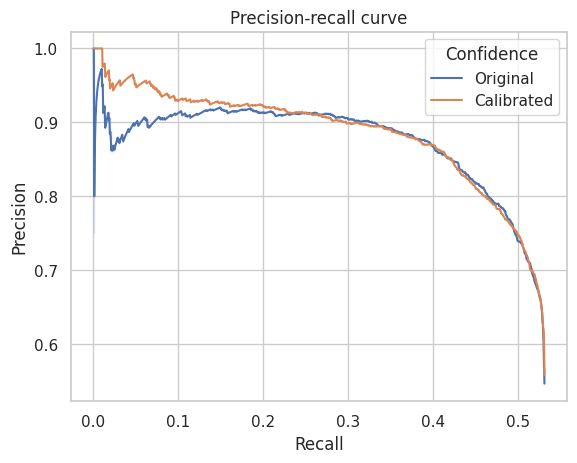

In [18]:
# -- Plot precision-recall curve
def compute_precision_recall_curve(
    dataset: pd.DataFrame,
    confidence_column: str,
    label_column: str,
    name: str,
) -> pd.DataFrame:
    original = dataset[[confidence_column, label_column]]
    original = original.sort_values(by=confidence_column, ascending=False)
    cum_correct = np.cumsum(original[label_column])
    precision = cum_correct / np.arange(1, len(original) + 1)
    recall = cum_correct / len(original)
    metrics = pd.DataFrame({"precision": precision, "recall": recall}).reset_index(
        drop=True
    )
    metrics["name"] = name
    return metrics


original = compute_precision_recall_curve(
    dataset=test_dataset.metadata,
    confidence_column="confidence",
    label_column="correct",
    name="Original",
)
calibrated = compute_precision_recall_curve(
    dataset=test_dataset.metadata,
    confidence_column="calibrated_confidence",
    label_column="correct",
    name="Calibrated",
)
metrics = pd.concat([original, calibrated], axis=0).reset_index(drop=True)
metrics["fdr"] = 1 - metrics["precision"]

ax = sns.lineplot(data=metrics, x="recall", y="precision", hue="name")
ax.set(xlabel="Recall", ylabel="Precision", title="Precision-recall curve")
ax.legend(title="Confidence")
plt.show()

In [19]:
# JVG: Maybe add some interpretation of the plot here? Example below

1. At **low recall values (<0.1)**, the calibrated curve is consistently above the original, meaning calibration improves precision when only the most confident predictions are considered.

2. For **medium recall (0.1 – 0.3)**, the calibrated model generally maintains slightly higher or similar precision than the original.

3. At **higher recall (>0.3)**, both curves overlap closely, with minimal differences.

4. At the very end (close to recall 0.5), both models collapse in precision (as expected, since more false positives are included).


Calibration makes the confidence scores more reliable, particularly in the high-precision, low-recall regime (top predictions). This suggests that after calibration, when the model assigns a high confidence score, it’s more trustworthy.

### B. Confidence score transformation

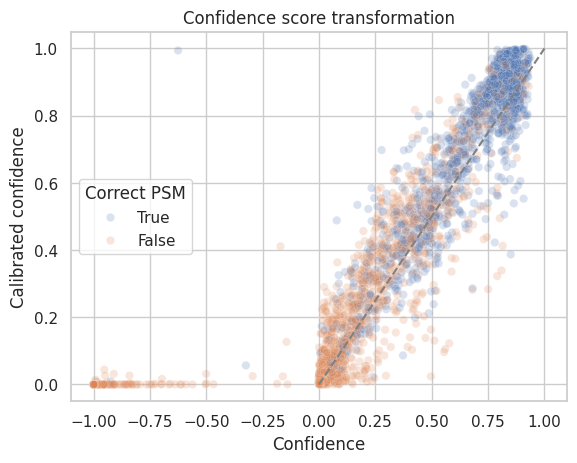

In [20]:
# -- Plot confidence score transformation
data = test_dataset.metadata[["confidence", "calibrated_confidence", "correct"]].copy(
    deep=True
)
data = data.dropna(subset=["confidence", "calibrated_confidence", "correct"])
data["correct"] = (
    data["correct"]
    .map({True: "True", False: "False"})
    .astype(pd.CategoricalDtype(categories=["True", "False"], ordered=True))
)

ax = sns.scatterplot(
    data=data,
    x="confidence",
    y="calibrated_confidence",
    hue="correct",
    alpha=0.2,
    legend=True,
)
ax.plot([0.0, 1.0], [0.0, 1.0], color="grey", linestyle="--")
ax.set(
    xlabel="Confidence",
    ylabel="Calibrated confidence",
    title="Confidence score transformation",
)

legend = ax.get_legend()
if legend is not None:
    legend.set_title("Correct PSM")

plt.show()

In [21]:
# JVG: Whay are some of the Casanovo confidences in the range [-1, 0]?

In [37]:
# JVG: interactive version
import plotly.express as px

# Prepare the data with predictions and ground truth
data = test_dataset.metadata[
    ["confidence", "calibrated_confidence", "correct", "prediction_untokenised", "sequence_untokenised"]
].copy(deep=True)
data = data.dropna(subset=["confidence", "calibrated_confidence", "correct"])
data["correct"] = data["correct"].map({True: "True", False: "False"})

# Define the same colour mapping as seaborn (blue for True, orange for False)
color_map = {"True": "#1f77b4", "False": "#ff7f0e"}

# Create interactive scatter plot
fig = px.scatter(
    data,
    x="confidence",
    y="calibrated_confidence",
    color="correct",
    color_discrete_map=color_map,
    hover_data={
        "prediction_untokenised": True,
        "sequence_untokenised": True,
        "confidence": ":.3f",
        "calibrated_confidence": ":.3f",
    },
    opacity=0.2,
    title="Confidence score transformation",
    labels={
        "confidence": "Original confidence",
        "calibrated_confidence": "Calibrated confidence",
        "correct": "Correct PSM",
        "prediction_untokenised": "Predicted peptide",
        "sequence_untokenised": "Ground truth peptide",
    },
)

# Add diagonal line y=x
fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=1,
    y1=1,
    line=dict(color="grey", dash="dash"),
)

# Legend
fig.update_layout(
    legend_title_text="Correct PSM",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
)

fig.show()

In [38]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def create_interactive_confidence_plot(test_dataset):
    """
    Create an interactive confidence score transformation plot with hover tooltips
    showing predicted and ground truth peptides.
    
    Args:
        test_dataset: CalibrationDataset with metadata containing confidence scores and peptides
    
    Returns:
        plotly.graph_objects.Figure: Interactive plot
    """
    
    # Prepare the data
    data = test_dataset.metadata[
        ["confidence", "calibrated_confidence", "correct", "prediction_untokenised", "sequence_untokenised"]
    ].copy(deep=True)
    
    # Remove rows with missing data
    data = data.dropna(subset=["confidence", "calibrated_confidence", "correct"])
    
    # Convert correct column to string for better visualization
    data["correct_str"] = data["correct"].map({True: "Correct", False: "Incorrect"})
    
    # Handle missing peptide sequences (replace NaN with "N/A")
    data["prediction_untokenised"] = data["prediction_untokenised"].fillna("N/A")
    data["sequence_untokenised"] = data["sequence_untokenised"].fillna("N/A")
    
    # Create hover text
    data["hover_text"] = (
        "Predicted: " + data["prediction_untokenised"].astype(str) + "<br>" +
        "Ground Truth: " + data["sequence_untokenised"].astype(str) + "<br>" +
        "Original Confidence: " + data["confidence"].round(3).astype(str) + "<br>" +
        "Calibrated Confidence: " + data["calibrated_confidence"].round(3).astype(str)
    )
    
    # Create the interactive plot
    fig = px.scatter(
        data,
        x="confidence",
        y="calibrated_confidence",
        color="correct_str",
        color_discrete_map={"Correct": "#1f77b4", "Incorrect": "#ff7f0e"},
        opacity=0.6,
        title="Interactive Confidence Score Transformation",
        labels={
            "confidence": "Original Confidence",
            "calibrated_confidence": "Calibrated Confidence",
            "correct_str": "PSM Status"
        },
        hover_data=None  # We'll use custom hover text
    )
    
    # Update hover template to use our custom text
    fig.update_traces(
        hovertemplate="<b>%{customdata}</b><extra></extra>",
        customdata=data["hover_text"]
    )
    
    # Add the diagonal reference line (y = x)
    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode="lines",
            line=dict(color="gray", dash="dash", width=1),
            name="Perfect Calibration (y=x)",
            hovertemplate="Perfect Calibration Line<extra></extra>"
        )
    )
    
    # Update layout
    fig.update_layout(
        width=800,
        height=600,
        xaxis=dict(range=[0, 1], title="Original Confidence"),
        yaxis=dict(range=[0, 1], title="Calibrated Confidence"),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        hovermode="closest"
    )
    
    return fig

# Example usage (replace with your actual test_dataset):
# fig = create_interactive_confidence_plot(test_dataset)
# fig.show()

# Alternative version if you want to save as HTML:
def save_interactive_plot(test_dataset, filename="confidence_transformation_plot.html"):
    """Save the interactive plot as an HTML file."""
    fig = create_interactive_confidence_plot(test_dataset)
    fig.write_html(filename)
    print(f"Interactive plot saved as {filename}")
    return fig

# If you want to customize the plot further, here's a more advanced version:
def create_advanced_interactive_confidence_plot(test_dataset, sample_size=None):
    """
    Create an advanced interactive plot with additional customization options.
    
    Args:
        test_dataset: CalibrationDataset with metadata
        sample_size: Optional int to randomly sample points for better performance
    """
    
    # Prepare the data
    data = test_dataset.metadata[
        ["confidence", "calibrated_confidence", "correct", "prediction_untokenised", 
         "sequence_untokenised", "precursor_charge", "precursor_mass"]
    ].copy(deep=True)
    
    # Remove rows with missing data
    data = data.dropna(subset=["confidence", "calibrated_confidence", "correct"])
    
    # Sample data if specified (for better performance with large datasets)
    if sample_size and len(data) > sample_size:
        data = data.sample(n=sample_size, random_state=42)
    
    # Convert correct column to string
    data["correct_str"] = data["correct"].map({True: "Correct", False: "Incorrect"})
    
    # Handle missing peptide sequences
    data["prediction_untokenised"] = data["prediction_untokenised"].fillna("N/A")
    data["sequence_untokenised"] = data["sequence_untokenised"].fillna("N/A")
    
    # Create detailed hover text
    data["hover_text"] = (
        "<b>Peptide Information:</b><br>" +
        "Predicted: " + data["prediction_untokenised"].astype(str) + "<br>" +
        "Ground Truth: " + data["sequence_untokenised"].astype(str) + "<br><br>" +
        "<b>Confidence Scores:</b><br>" +
        "Original: " + data["confidence"].round(4).astype(str) + "<br>" +
        "Calibrated: " + data["calibrated_confidence"].round(4).astype(str) + "<br><br>" +
        "<b>Spectrum Info:</b><br>" +
        "Charge: " + data["precursor_charge"].fillna(0).astype(int).astype(str) + "<br>" +
        "Precursor Mass: " + data["precursor_mass"].fillna(0).round(2).astype(str) + " Da"
    )
    
    # Create the plot
    fig = go.Figure()
    
    # Add scatter points for correct PSMs
    correct_data = data[data["correct"] == True]
    fig.add_trace(
        go.Scatter(
            x=correct_data["confidence"],
            y=correct_data["calibrated_confidence"],
            mode="markers",
            name="Correct PSMs",
            marker=dict(
                color="#2E8B57",  # Sea green
                opacity=0.6,
                size=6
            ),
            customdata=correct_data["hover_text"],
            hovertemplate="%{customdata}<extra></extra>"
        )
    )
    
    # Add scatter points for incorrect PSMs
    incorrect_data = data[data["correct"] == False]
    fig.add_trace(
        go.Scatter(
            x=incorrect_data["confidence"],
            y=incorrect_data["calibrated_confidence"],
            mode="markers",
            name="Incorrect PSMs",
            marker=dict(
                color="#DC143C",  # Crimson
                opacity=0.6,
                size=6
            ),
            customdata=incorrect_data["hover_text"],
            hovertemplate="%{customdata}<extra></extra>"
        )
    )
    
    # Add diagonal reference line
    fig.add_trace(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode="lines",
            line=dict(color="gray", dash="dash", width=2),
            name="Perfect Calibration (y=x)",
            hovertemplate="Perfect Calibration Line<extra></extra>"
        )
    )
    
    # Update layout
    fig.update_layout(
        title={
            'text': "Interactive Confidence Score Transformation<br><sub>Hover over points to see peptide details</sub>",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis=dict(
            range=[0, 1], 
            title="Original Confidence",
            showgrid=True,
            gridcolor="lightgray"
        ),
        yaxis=dict(
            range=[0, 1], 
            title="Calibrated Confidence",
            showgrid=True,
            gridcolor="lightgray"
        ),
        width=900,
        height=700,
        legend=dict(
            yanchor="top",
            y=0.98,
            xanchor="left",
            x=0.02,
            bgcolor="rgba(255,255,255,0.8)"
        ),
        hovermode="closest",
        plot_bgcolor="white"
    )
    
    return fig

# Usage examples:
# Basic version:
# fig = create_interactive_confidence_plot(test_dataset)
# fig.show()

# Advanced version with sampling for large datasets:
fig = create_advanced_interactive_confidence_plot(test_dataset, sample_size=5000)
fig.show()

# Save to HTML:
# save_interactive_plot(test_dataset, "my_confidence_plot.html")

### C. Confidence distributions

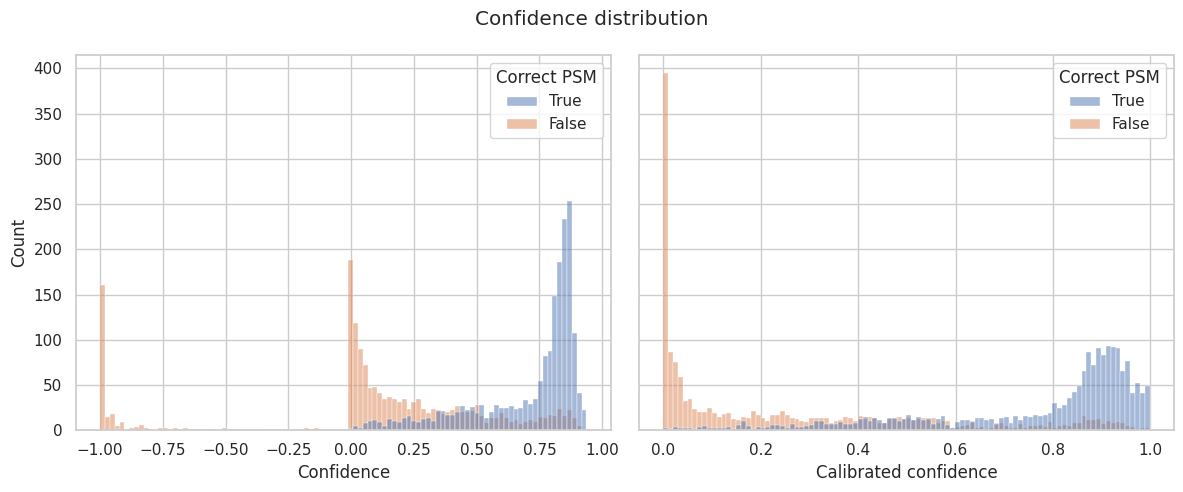

In [22]:
# -- Plot confidence distribution
data = test_dataset.metadata[["confidence", "calibrated_confidence", "correct"]].copy(
    deep=True
)
data = data.dropna(subset=["confidence", "calibrated_confidence", "correct"])
data["correct"] = (
    data["correct"]
    .map({True: "True", False: "False"})
    .astype(pd.CategoricalDtype(categories=["True", "False"], ordered=True))
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Raw confidence distribution
ax0 = sns.histplot(
    data=data,
    x="confidence",
    hue="correct",
    hue_order=["True", "False"],
    bins=100,
    multiple="layer",
    alpha=0.5,
    legend=True,
    ax=axes[0],
)
axes[0].set(xlabel="Confidence", ylabel="Count")
sns.move_legend(axes[0], "best", title="Correct PSM")

# Calibrated confidence distribution
ax1 = sns.histplot(
    data=data,
    x="calibrated_confidence",
    hue="correct",
    hue_order=["True", "False"],
    bins=100,
    multiple="layer",
    alpha=0.5,
    legend=True,
    ax=axes[1],
)
axes[1].set(xlabel="Calibrated confidence", ylabel="Count")
sns.move_legend(axes[1], "best", title="Correct PSM")

fig.suptitle("Confidence distribution")
plt.tight_layout()

plt.show()

### D. Calibration curves

/home/j-vangoey/code/worktree_winnow/.venv/lib/python3.12/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/home/j-vangoey/code/worktree_winnow/.venv/lib/python3.12/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/home/j-vangoey/code/worktree_winnow/.venv/lib/python3.12/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/home/j-vangoey/code/worktree_winnow/.venv/lib/python3.12/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


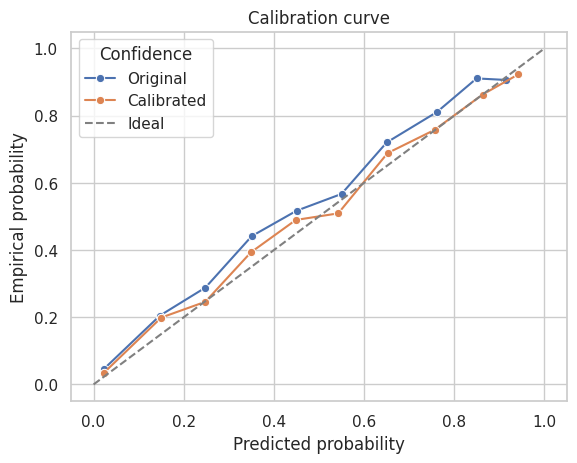

In [23]:
# Plot calibration curve
def compute_calibration_curve(
    df: pd.DataFrame, pred_col: str, label_col: str, name: str, n_bins: int = 20
) -> pd.DataFrame:
    data = df[[pred_col, label_col]].dropna().copy(deep=True)
    data[pred_col] = data[pred_col].clip(0.0, 1.0)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_cats = pd.cut(data[pred_col], bins=bins, include_lowest=True)
    bin_cats.name = "bin"
    grouped = (
        data.groupby(bin_cats, observed=True)
        .agg(
            pred_mean=(pred_col, "mean"),
            empirical=(label_col, "mean"),
            count=(label_col, "size"),
        )
        .reset_index()
    )
    grouped = grouped[grouped["count"] > 0]
    grouped["bin_center"] = grouped["bin"].apply(lambda iv: (iv.left + iv.right) / 2)
    grouped["name"] = name
    return grouped[["pred_mean", "empirical", "count", "bin_center", "name"]]


metrics_orig = compute_calibration_curve(
    test_dataset.metadata, "confidence", "correct", name="Original", n_bins=10
)
metrics_cal = compute_calibration_curve(
    test_dataset.metadata,
    "calibrated_confidence",
    "correct",
    name="Calibrated",
    n_bins=10,
)
metrics = pd.concat([metrics_orig, metrics_cal], ignore_index=True)

ax = sns.lineplot(data=metrics, x="pred_mean", y="empirical", hue="name", marker="o")
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle="--", color="gray", label="Ideal")
ax.set(
    xlabel="Predicted probability",
    ylabel="Empirical probability",
    title="Calibration curve",
)
ax.legend(title="Confidence")
plt.show()


## 7. FDR control: two approaches

1. **Database-grounded FDR**
  - Use when you have ground-truth peptide labels for this dataset (good for evaluation/benchmarking).
  - Outputs: a confidence cutoff at a target FDR; optional per-PSM FDR via `add_psm_fdr`.
  - Extrapolates poorly to real *de novo* workflows

2. **Empirical Bayes (label-free) FDR**
  - Use on unlabelled datasets; fits a beta-mixture model to (calibrated) confidences.
  - No ground truth labels required
  - Outputs: a confidence cutoff at a target FDR; per-PSM metrics: FDR (`psm_fdr`), posterior error probability (`psm_pep`), and p-value (`psm_p_value`).

Fit on the column you intend to use downstream (e.g., `calibrated_confidence`).

In [24]:
# -- Database-grounded FDR control
database_grounded_fdr_control = DatabaseGroundedFDRControl(
    confidence_feature="calibrated_confidence"
)
database_grounded_fdr_control.fit(
    dataset=test_dataset.metadata, residue_masses=RESIDUE_MASSES
)
print(
    "Database-grounded FDR control confidence cutoff at 5% FDR using calibrated confidence:",
    database_grounded_fdr_control.get_confidence_cutoff(threshold=0.05),
)

Database-grounded FDR control confidence cutoff at 5% FDR using calibrated confidence: 0.9520774630052138


In [25]:
# -- Mixture FDR control (Winnow-specific)
mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=test_dataset.metadata["calibrated_confidence"])
print(
    "Mixture FDR control confidence cutoff at 5% FDR using calibrated confidence:",
    mixture_fdr_control.get_confidence_cutoff(threshold=0.05),
)

INFO:2025-09-22 08:45:27,966:jax._src.xla_bridge:924: Unable to initialize backend 'cuda': 
INFO:2025-09-22 08:45:27,966:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-22 08:45:27,968:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
100%|██████████| 5000/5000 [00:02<00:00, 2112.49it/s, init loss: 741.4962, avg. loss [4751-5000]: -2358.7939]


Mixture FDR control confidence cutoff at 5% FDR using calibrated confidence: 0.9999993285528035


In [26]:
# -- Add PSM-specific FDR metrics to the dataset
test_dataset_winnow_metrics = mixture_fdr_control.add_psm_fdr(
    test_dataset.metadata, confidence_col="calibrated_confidence"
)
test_dataset_winnow_metrics = mixture_fdr_control.add_psm_pep(
    test_dataset_winnow_metrics, confidence_col="calibrated_confidence"
)
test_dataset_winnow_metrics = mixture_fdr_control.add_psm_p_value(
    test_dataset_winnow_metrics, confidence_col="calibrated_confidence"
)

test_dataset_dbg_metrics = database_grounded_fdr_control.add_psm_fdr(
    test_dataset.metadata, confidence_col="calibrated_confidence"
)

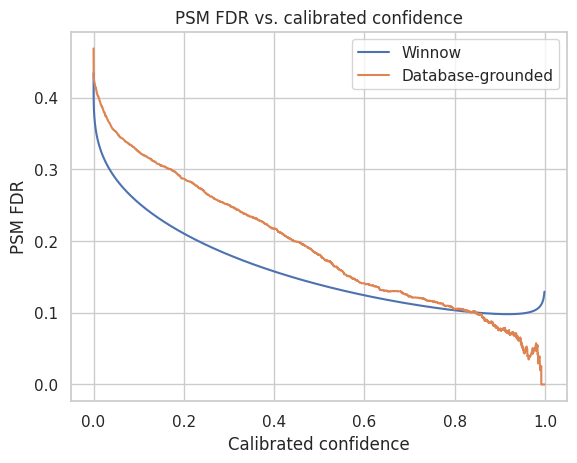

In [27]:
metrics = test_dataset_winnow_metrics[["calibrated_confidence", "psm_fdr"]].copy(
    deep=True
)
ax = sns.lineplot(
    x=np.asarray(test_dataset_winnow_metrics["calibrated_confidence"], dtype=float),
    y=np.asarray(test_dataset_winnow_metrics["psm_fdr"], dtype=float),
    errorbar=None,
    label="Winnow",
)
ax = sns.lineplot(
    x=np.asarray(test_dataset_dbg_metrics["calibrated_confidence"], dtype=float),
    y=np.asarray(test_dataset_dbg_metrics["psm_fdr"], dtype=float),
    errorbar=None,
    label="Database-grounded",
)
ax.set_xlabel("Calibrated confidence")
ax.set_ylabel("PSM FDR")
ax.set_title("PSM FDR vs. calibrated confidence")
ax.grid(True)
plt.show()

## 8. Applying to new data

This section simulates how you'd use winnow in a real *de novo* sequencing pipeline, when PSMs from other engines are not available.

In [28]:
# -- Load the raw, unlabelled data
logger.info("Loading raw dataset.")
dataset = CalibrationDataset.from_predictions_csv(
    spectrum_path="winnow-ms-datasets/helaqc_raw_less_train.parquet",
    beam_predictions_path="winnow-ms-datasets/helaqc_raw_less_train_beams.csv",
)

logger.info("Filtering dataset.")
raw_filtered_dataset = (
    dataset.filter_entries(
        metadata_predicate=lambda row: not isinstance(row["prediction"], list),
    )
    .filter_entries(metadata_predicate=lambda row: not row["prediction"])
    .filter_entries(
        metadata_predicate=lambda row: row["precursor_charge"] > 6
    )  # Prosit-specific filtering
    .filter_entries(
        metadata_predicate=lambda row: len(row["prediction"]) > 30
    )  # Prosit-specific filtering
    .filter_entries(
        predictions_predicate=lambda row: len(row[1].sequence) > 30
    )  # Prosit-specific filtering
)

Loading raw dataset.


AttributeError: type object 'CalibrationDataset' has no attribute 'from_predictions_csv'

In [ ]:
# -- Predict on the raw, unlabelled data
calibrator.predict(raw_filtered_dataset)

In [ ]:
# -- Mixture FDR control (Winnow-specific)
mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=raw_filtered_dataset.metadata["calibrated_confidence"])
confidence_cutoff = mixture_fdr_control.get_confidence_cutoff(threshold=0.05)
print(
    f"Mixture FDR control confidence cutoff at 5% FDR using calibrated confidence: {confidence_cutoff}"
)

In [ ]:
# -- Plot confidence distribution and confidence cutoff at 5% FDR
data = raw_filtered_dataset.metadata["calibrated_confidence"].copy(deep=True)

ax = sns.histplot(data, bins=100)
ax.axvline(confidence_cutoff, color="grey", linestyle="--")
ax.set(xlabel="Calibrated confidence", ylabel="Count", title="Confidence distribution")
plt.show()

In [ ]:
# -- Add PSM-specific FDR metrics to the dataset
raw_filtered_dataset_metadata = mixture_fdr_control.add_psm_fdr(
    raw_filtered_dataset.metadata, confidence_col="calibrated_confidence"
)
raw_filtered_dataset_metadata = mixture_fdr_control.add_psm_pep(
    raw_filtered_dataset_metadata, confidence_col="calibrated_confidence"
)
raw_filtered_dataset_metadata = mixture_fdr_control.add_psm_p_value(
    raw_filtered_dataset_metadata, confidence_col="calibrated_confidence"
)

In [ ]:
# -- Filter dataset to only include PSMs with calibrated confidence above the cutoff
filtered_dataset = raw_filtered_dataset.filter_entries(
    metadata_predicate=lambda row: row["calibrated_confidence"] >= confidence_cutoff
)

print(f"Number of PSMs in filtered dataset: {len(filtered_dataset)}")

## 9. Adding custom features

How to implement your own calibration features:

In [ ]:
class CustomFeature(CalibrationFeatures):
    @property
    def name(self) -> str:
        return "My Custom Feature"

    def compute(self, dataset: CalibrationDataset) -> None:
        # Your feature computation logic
        pass

## 10. Saving and reusing a calibrator

If you plan to apply the same feature configuration to external data, you can save and reload the calibrator.

In [ ]:
# -- Save
out_dir = Path("outputs/helaqc_calibrator")
ProbabilityCalibrator.save(calibrator, out_dir)

# -- Load
loaded = ProbabilityCalibrator.load(out_dir)
print("Loaded features:", loaded.features)

## 11. CLI usage

You can run the same workflow headlessly via the CLI.

```bash
# Train a calibrator
winnow train \
  --data-source instanovo \
  --dataset-config-path configs/helaqc_labelled.yaml \
  --model-output-folder outputs/helaqc_calibrator \
  --dataset-output-path outputs/helaqc_train_outputs.csv

# Predict + FDR on new data
winnow predict \
  --data-source instanovo \
  --dataset-config-path configs/helaqc_raw.yaml \
  --model-folder outputs/helaqc_calibrator \
  --method winnow \
  --fdr-threshold 0.05 \
  --confidence-column calibrated_confidence \
  --output-path outputs/helaqc_filtered.csv
```

## 12. Using Winnow without Prosit (offline/minimal)

If you don't have Prosit access, have data with many diverse modifications, or want a minimal setup, you can disable Prosit-dependent features and still benefit from calibration using features available locally.

In [ ]:
# Minimal feature set: no Prosit dependency
cal_min = ProbabilityCalibrator(SEED)
cal_min.add_feature(MassErrorFeature(residue_masses=RESIDUE_MASSES))
cal_min.add_feature(BeamFeatures())

cal_min.fit(train_dataset)
cal_min.predict(test_dataset)
print("Finished training minimal calibrator. Columns:", cal_min.columns)

## 13. Pretrained general calibrator (InstaNovo)

We have published a pretrained calibrator for InstaNovo that uses the default feature set (Mass Error, Prosit spectral, Prosit iRT, Chimeric, Beam) on Hugging Face. You can load it and apply it to your own datasets without retraining!

**Notes**:
- Prosit-dependent features are still computed at inference, so Prosit access is required.
- Ensure your modification tokens and input columns match this tutorial's format.

In [ ]:
# -- Download the general model
calib_repo = "InstaDeepAI/winnow-general-model"
calib_dir = Path("./winnow-general-model")

In [ ]:
snapshot_download(repo_id=calib_repo, repo_type="model", local_dir=calib_dir)

In [ ]:
# -- Load the general model
general_model = ProbabilityCalibrator.load(calib_dir)
print("Loaded pretrained features:", general_model.features)

Let's replicate results in our paper on the Immunopeptidomics-2 dataset

In [ ]:
# -- Download the Immunopeptidomics-2 dataset
snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    allow_patterns=["immuno2_labelled*.parquet", "immuno2_labelled*.csv"],
    local_dir=save_dir,
)

In [ ]:
# -- Load data
logger.info("Loading dataset.")
immuno2_dataset = CalibrationDataset.from_predictions_csv(
    spectrum_path="winnow-ms-datasets/immuno2_labelled.parquet",
    beam_predictions_path="winnow-ms-datasets/immuno2_labelled_beams.csv",
)

logger.info("Filtering dataset.")
immuno2_filtered_dataset = (
    immuno2_dataset.filter_entries(
        metadata_predicate=lambda row: not isinstance(row["prediction"], list),
    )
    .filter_entries(metadata_predicate=lambda row: not row["prediction"])
    .filter_entries(
        metadata_predicate=lambda row: row["precursor_charge"] > 6
    )  # Prosit-specific filtering, see https://github.com/Nesvilab/FragPipe/issues/1775
    .filter_entries(
        metadata_predicate=lambda row: len(row["prediction"]) > 30
    )  # Prosit-specific filtering
    .filter_entries(
        predictions_predicate=lambda row: len(row[1].sequence) > 30
    )  # Prosit-specific filtering
)

In [ ]:
# -- Predict
general_model.predict(immuno2_filtered_dataset)

In [ ]:
original = compute_precision_recall_curve(
    dataset=immuno2_filtered_dataset.metadata,
    confidence_column="confidence",
    label_column="correct",
    name="Original",
)
calibrated = compute_precision_recall_curve(
    dataset=immuno2_filtered_dataset.metadata,
    confidence_column="calibrated_confidence",
    label_column="correct",
    name="Calibrated",
)
metrics = pd.concat([original, calibrated], axis=0).reset_index(drop=True)
metrics["fdr"] = 1 - metrics["precision"]

ax = sns.lineplot(data=metrics, x="recall", y="precision", hue="name")
ax.set(xlabel="Recall", ylabel="Precision", title="Precision-recall curve")
ax.legend(title="Confidence")
plt.show()

In [ ]:
metrics_orig = compute_calibration_curve(
    immuno2_filtered_dataset.metadata,
    "confidence",
    "correct",
    name="Original",
    n_bins=10,
)
metrics_cal = compute_calibration_curve(
    immuno2_filtered_dataset.metadata,
    "calibrated_confidence",
    "correct",
    name="Calibrated",
    n_bins=10,
)
metrics = pd.concat([metrics_orig, metrics_cal], ignore_index=True)

ax = sns.lineplot(data=metrics, x="pred_mean", y="empirical", hue="name", marker="o")
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle="--", color="gray", label="Ideal")
ax.set(
    xlabel="Predicted probability",
    ylabel="Empirical probability",
    title="Calibration curve",
)
ax.legend(title="Confidence")
plt.show()

In [ ]:
# -- Compute FDR
mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(
    dataset=immuno2_filtered_dataset.metadata["calibrated_confidence"]
)
confidence_cutoff = mixture_fdr_control.get_confidence_cutoff(threshold=0.05)
print(
    f"Mixture FDR control confidence cutoff at 5% FDR using calibrated confidence: {confidence_cutoff}"
)

database_grounded_fdr_control = DatabaseGroundedFDRControl(
    confidence_feature="calibrated_confidence"
)
database_grounded_fdr_control.fit(
    dataset=immuno2_filtered_dataset.metadata, residue_masses=RESIDUE_MASSES
)
confidence_cutoff_dbg = database_grounded_fdr_control.get_confidence_cutoff(
    threshold=0.05
)
print(
    f"Database-grounded FDR control confidence cutoff at 5% FDR using calibrated confidence: {confidence_cutoff_dbg}"
)

# -- Calculate PSM-specific FDR metrics
immuno2_winnow_psm_fdr = mixture_fdr_control.add_psm_fdr(
    immuno2_filtered_dataset.metadata, confidence_col="calibrated_confidence"
)[["spectrum_id", "calibrated_confidence", "psm_fdr"]]

immuno2_dbg_psm_fdr = database_grounded_fdr_control.add_psm_fdr(
    immuno2_filtered_dataset.metadata, confidence_col="calibrated_confidence"
)[["spectrum_id", "calibrated_confidence", "psm_fdr"]]

In [ ]:
## TODO: Add database-grounded line

metrics = immuno2_winnow_psm_fdr[["calibrated_confidence", "psm_fdr"]].copy(deep=True)
ax = sns.lineplot(
    x=np.asarray(immuno2_winnow_psm_fdr["calibrated_confidence"], dtype=float),
    y=np.asarray(immuno2_winnow_psm_fdr["psm_fdr"], dtype=float),
    errorbar=None,
    label="Winnow",
)
ax = sns.lineplot(
    x=np.asarray(immuno2_dbg_psm_fdr["calibrated_confidence"], dtype=float),
    y=np.asarray(immuno2_dbg_psm_fdr["psm_fdr"], dtype=float),
    errorbar=None,
    label="Database-grounded",
)
ax.set_xlabel("Calibrated confidence")
ax.set_ylabel("PSM FDR")
ax.set_title("PSM FDR vs. calibrated confidence")
ax.grid(True)
plt.show()

## Tips and troubleshooting
- Ensure your spectrum data and beam predictions share a common, unique `spectrum_id` for merging.
- Prosit-dependent features filter unsupported modifications; if you see many rows removed, review modification tokens.
- If beam results often contain fewer than 2-3 candidates, chimeric/beam features may carry limited information (warnings will appear).
- Always validate on a labelled subset or via consistency checks before deploying to new datasets.

## Resources
- 📚 GitHub: https://github.com/instadeepai/winnow
- 🔧 CLI: `winnow --help`